In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import nan
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import os
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

In [2]:
with open('demand_models_spec.pkl', 'rb') as f:
     models_dict = pickle.load(f)

In [3]:
brand = 'Fendi'
state = 'study'
#state = 'train'
if brand not in models_dict:
    models_dict[brand] = {}

In [4]:
df = pd.read_pickle('../data/%s_refined.pkl' %brand)

with open('../data/search_trends.pkl', 'rb') as f:
    trends_dict = pickle.load(f)

In [5]:
df = df[df['ever_sold'] == 1]

In [6]:
#add new trends files

cols = [col for col in df.columns if 'search' not in col]
df = df[cols]

In [7]:
list(trends_dict[brand].keys())

['search_tradesy_fendi', 'search_fendi', 'search_fendi_kan_i']

In [8]:
for keyword in list(trends_dict[brand].keys()):
    df[keyword] = df['sc_date'].map(trends_dict[brand][keyword])

In [9]:
supply_stats = pd.pivot_table(df[df.apply(lambda x: x['sc_date'] == x['sc_date_first_date'], axis = 1)],
                      values = 'bags_price_refined', index = 'sc_date' , 
                              aggfunc = ['count', 'sum']).reset_index()[1:]

supply_dict = dict(zip(supply_stats['sc_date'], supply_stats['count']['bags_price_refined']))
price_dict = dict(zip(supply_stats['sc_date'], supply_stats['sum']['bags_price_refined']))

In [10]:
X = pd.DataFrame({'sc_date': df['sc_date'].drop_duplicates()}).sort_values('sc_date').reset_index(drop=True)

In [11]:
max_df_date = max(X['sc_date'])
min_df_date = min(X['sc_date'])

In [12]:
stats = pd.pivot_table(df[df.apply(lambda x: x['sc_date'] == x['sc_date_last_date'] and 
                                   x['status'] == 'Complete', axis = 1)],
                      values = 'id', index = 'sc_date' , aggfunc = 'count').reset_index()[:-1]

In [13]:
X = pd.merge(X, stats, how='left').fillna(0)

In [14]:
def demand_trend(cur_date, last_n):
    if cur_date - datetime.timedelta(days = last_n * 2) <= max_df_date:
        demand_current = sum(X[X['sc_date'].map(lambda x: 
            cur_date - datetime.timedelta(days = last_n) <= x < cur_date)]['id'])
        demand_basis = sum(X[X['sc_date'].map(lambda x: 
            cur_date - datetime.timedelta(days = last_n * 2) <= x < 
            cur_date - datetime.timedelta(days = last_n))]['id'])
        return demand_current, demand_current / demand_basis if demand_basis > 0 else 0
    else:
        return nan, nan

In [15]:
X['demand_7'], X['demand_7_trend'] = zip(*X['sc_date'].map(lambda x: demand_trend(x, 7)))

In [16]:
#X['demand_14'], X['demand_14_trend'] = zip(*X['sc_date'].map(lambda x: demand_trend(x, 14)))

In [17]:
def search_trend(date, keyword, lag=7):
    date = date - datetime.timedelta(days=lag)
    return trends_dict[brand][keyword][date]

In [18]:
for column in list(trends_dict[brand].keys()):
    X[column+'_7'] = X['sc_date'].map(lambda x: search_trend(x, column, 7))
    X[column+'_0'] = X['sc_date'].map(lambda x: search_trend(x, column, 0))
    X[column+'_14'] = X['sc_date'].map(lambda x: search_trend(x, column, 14))

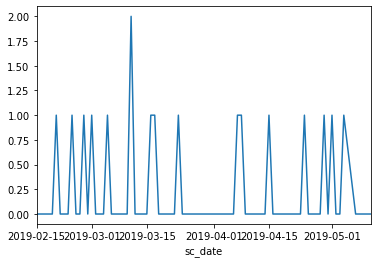

In [19]:
series1 = pd.Series(list(X['id']), index=X['sc_date'])
series1.plot()
plt.show()

In [20]:
def supply_trend(cur_date, last_n):
    min_date = cur_date - datetime.timedelta(days = last_n)
    if min_date >= min_df_date:
        supply_current = sum([supply_dict[date] for date in supply_dict.keys() if
                             min_date <= date < cur_date])
        prices_current = sum([price_dict[date] for date in price_dict.keys() if
                             min_date <= date < cur_date])
        return supply_current, prices_current / supply_current if supply_current > 0 else 0
    else:
        return nan, nan

In [21]:
X['supply_7'], X['supply_7_trend'] = zip(*X['sc_date'].map(lambda x: supply_trend(x, 7)))

In [22]:
def demand(date, n_days=30):
    max_date = date + datetime.timedelta(days=n_days)
    if max_date <= max_df_date:
        future_demand = sum(X[X['sc_date'].map(lambda x: 
            date < x <= max_date)]['id'])
        return future_demand
    else:
        return nan

In [23]:
X['demand'] = X['sc_date'].map(lambda x: demand(x, 30))

In [24]:
series = pd.Series(list(X['demand']), index=X['sc_date'])
'''series_1 = pd.Series(list(X['search_classic_flap_0']), index=X['sc_date'])
series_2 = pd.Series(list(X['search_tradesy_chanel_0']), index=X['sc_date'])
series_3 = pd.Series(list(X['search_chanel_0']), index=X['sc_date'])'''

"series_1 = pd.Series(list(X['search_classic_flap_0']), index=X['sc_date'])\nseries_2 = pd.Series(list(X['search_tradesy_chanel_0']), index=X['sc_date'])\nseries_3 = pd.Series(list(X['search_chanel_0']), index=X['sc_date'])"

In [25]:
series.dropna().index[-20]

datetime.date(2019, 3, 23)

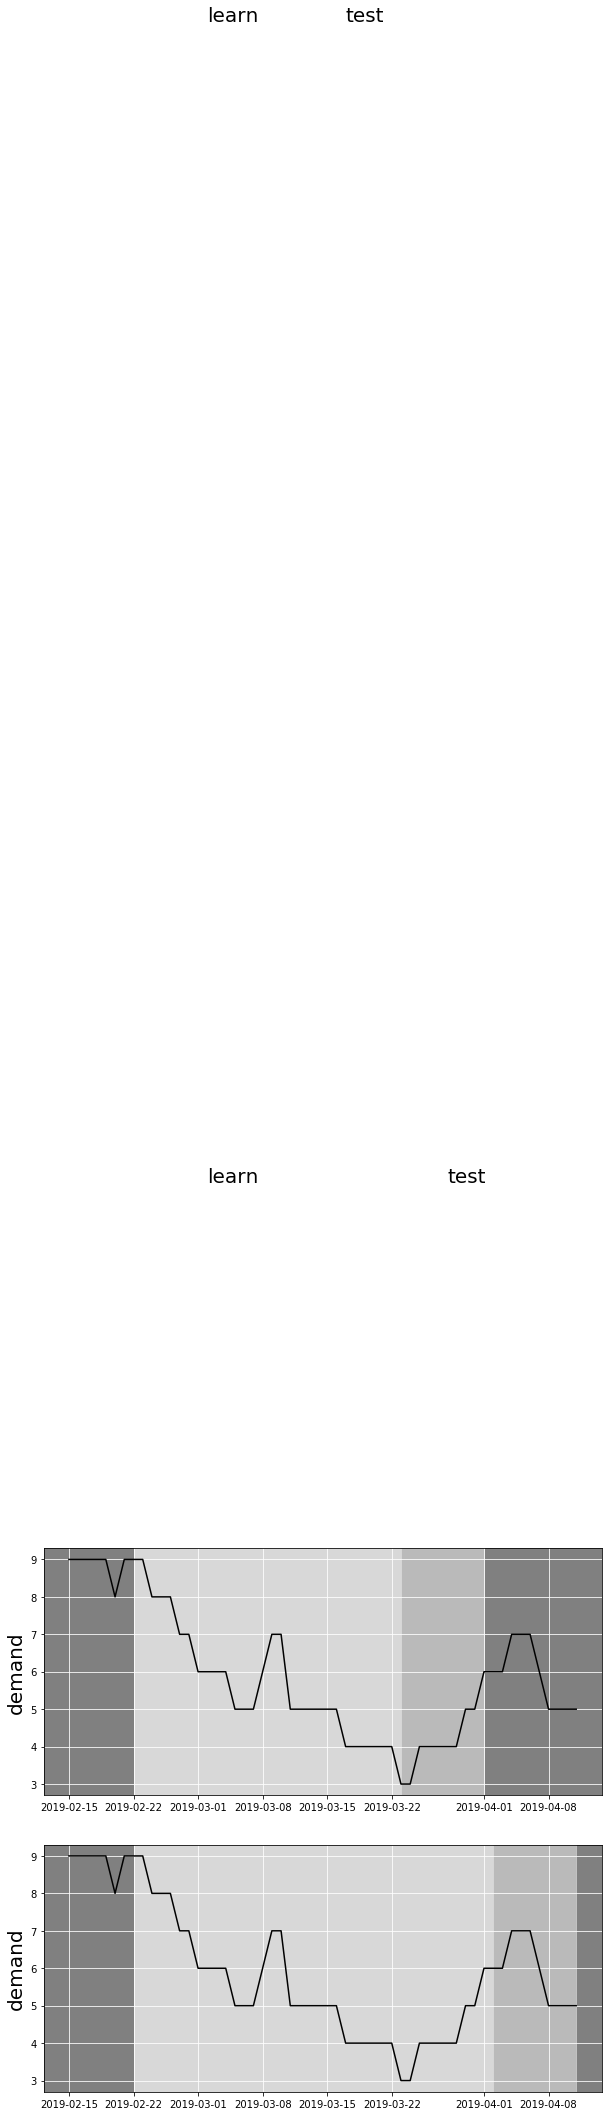

In [26]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1, sharey=ax1)

ax1.plot(series.dropna(), color='black')
ax1.axvspan(datetime.date(2019,2,22), series.dropna().index[-20], alpha=0.7, color='white')
ax1.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='lightgrey')
ax1.patch.set_facecolor('grey')
ax1.set_ylabel("demand", fontsize=20)
ax1.grid(True,color='white')

ax2.plot(series.dropna(), color='black')
ax2.axvspan(datetime.date(2019,2,22), series.dropna().index[-10], alpha=0.7, color='white')
ax2.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='lightgrey')
ax2.patch.set_facecolor('grey')
ax2.set_ylabel("demand", fontsize=20)

plt.text(datetime.date(2019,3,2), 58, 'learn', fontsize=20)
plt.text(datetime.date(2019,3,17), 58, 'test', fontsize=20)
plt.text(datetime.date(2019,3,2), 27, 'learn', fontsize=20)
plt.text(datetime.date(2019,3,28), 27, 'test', fontsize=20)
plt.grid(True,color='white')
plt.show()

In [27]:
X.columns

Index(['sc_date', 'id', 'demand_7', 'demand_7_trend', 'search_tradesy_fendi_7',
       'search_tradesy_fendi_0', 'search_tradesy_fendi_14', 'search_fendi_7',
       'search_fendi_0', 'search_fendi_14', 'search_fendi_kan_i_7',
       'search_fendi_kan_i_0', 'search_fendi_kan_i_14', 'supply_7',
       'supply_7_trend', 'demand'],
      dtype='object')

In [28]:
X['const'] = 1
cols = list(set(X.columns) - {'sc_date', 'id', 'const'})
lr_cols = list(set(X.columns) - {'sc_date', 'id', 'demand', 'const', 'supply_7'})
X = X.dropna()

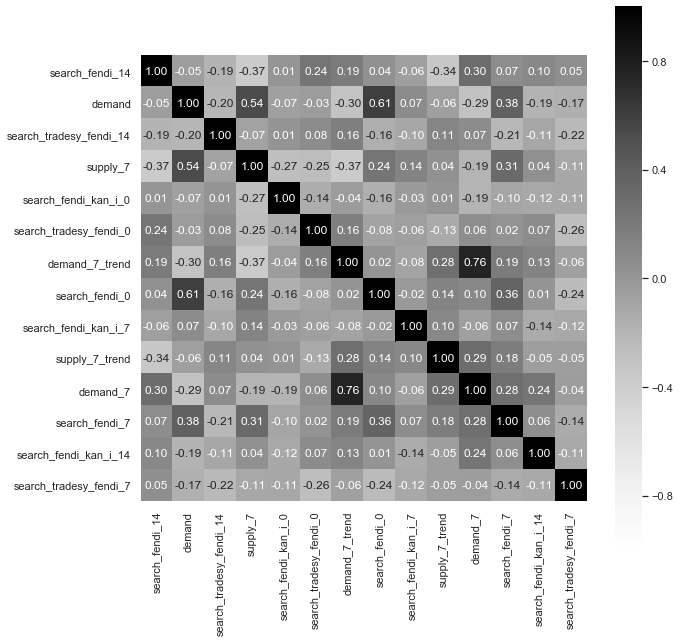

In [29]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(X[cols].dropna().corr(), annot = True, square=True, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'Greys')

# XGBRegressor

In [30]:
#X, y = X.dropna()[cols], X.dropna()['demand']
y_pred_xgb = list()
if state == 'study':
    rmse_xgb = list()
    for learn_size in [X.shape[0]-10, X.shape[0]-20]:
        df_train, df_test = X[cols][:learn_size], X[cols][learn_size:learn_size+10]
        #df_train, df_test = train_test_split(xgb_df[cols], test_size=0.3, random_state=12)

        X_train, X_test = df_train[list(set(cols) - {'demand'})],df_test[list(set(cols) - {'demand'})]
        y_train, y_test = df_train['demand'],df_test['demand']

        xgb = XGBRegressor(min_child_wieght=1,subsample=1,colsample_bytree=1,max_depth=9)
        xgb.fit(X_train,y_train)
        y_pred_xgb.append(list(xgb.predict(X_test)))
        #y_pred = [round(item, 0) for item in y_pred]
        rmse_xgb.append(np.sqrt(mean_squared_error(y_pred_xgb[-1],y_test)))
        print(y_test, y_pred_xgb)
    print(rmse_xgb)

46    6.0
47    6.0
48    7.0
49    7.0
50    7.0
51    6.0
52    5.0
53    5.0
54    5.0
55    5.0
Name: demand, dtype: float64 [[6.101599, 5.5245495, 5.387474, 4.177012, 4.219308, 5.3559093, 4.7711644, 5.4884386, 5.286676, 5.39157]]
36    3.0
37    3.0
38    4.0
39    4.0
40    4.0
41    4.0
42    4.0
43    5.0
44    5.0
45    6.0
Name: demand, dtype: float64 [[6.101599, 5.5245495, 5.387474, 4.177012, 4.219308, 5.3559093, 4.7711644, 5.4884386, 5.286676, 5.39157], [5.0973797, 5.3424835, 6.0144215, 4.7937145, 4.6528683, 4.376052, 4.4918942, 4.233293, 6.4230175, 6.306408]]
[1.3956871599524179, 1.3450064418890473]


In [31]:
if state == 'train':
    xgb_df = X[cols].dropna()
    df_train = xgb_df[cols]
    #df_train, df_test = train_test_split(xgb_df[cols], test_size=0.3, random_state=12)
    
    X_train = df_train[list(set(cols) - {'demand'})]
    y_train = df_train['demand']
    
    xgbr = XGBRegressor(min_child_wieght= 1,subsample=1,colsample_bytree = 1,max_depth = 9)
    xgbr.fit(X_train,y_train)
    models_dict[brand]['xgbr'] = {'spec': xgbr, 'features': cols}

In [32]:
if state == 'train':
    import shap
    shap.initjs()
    explainer = shap.TreeExplainer(xgbr)
    shap_values = explainer.shap_values(X_train.as_matrix())
    shap.summary_plot(shap_values, X_train)

# Linear Regression

In [33]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [34]:
from itertools import combinations
y_pred_mr = list()
mr_lower_pred = list()
mr_upper_pred = list()
if state == 'study':
    rmse_mr = list()
    for learn_size in [X.shape[0]-10, X.shape[0]-20]:
        good_models = {}
        for i in range(1,len(lr_cols)):
            print(i)
            for features in combinations(lr_cols, i):
                f = list(features)
                df_train= X[:learn_size]        
                X_train, y_train = df_train[f+['demand']].dropna()[f], df_train[f+['demand']].dropna()['demand']
                est = sm.OLS(y_train, X_train)
                est2 = est.fit()
                if len([pvalue for pvalue in est2.pvalues if pvalue < 0.05]) == i and est2.rsquared_adj > 0.9 and \
                est2.f_pvalue < 0.05:
                    good_models[tuple(f)] = {'p-values': est2.pvalues, 'r_adj':est2.rsquared_adj, 'f_stat': est2.f_pvalue}

                X_train, y_train = X[f+['demand', 'const']].dropna()[f+['const']], X[f+['demand']].dropna()['demand']
                est = sm.OLS(y_train, X_train)
                est2 = est.fit()
                if len([pvalue for pvalue in est2.pvalues if pvalue < 0.01]) == i+1 and est2.rsquared_adj > 0.9 and \
                est2.f_pvalue < 0.01:
                    good_models[tuple(f+['const'])] = {'p-values': est2.pvalues, 'r_adj':est2.rsquared_adj, 
                                                       'f_stat': est2.f_pvalue}
        if good_models:
            max_f_len = max([len(features) for features in good_models.keys()])
            max_r_adj = max([good_models[features]['r_adj'] for features in good_models.keys() if len(features) == max_f_len])
            f = [features for features in good_models.keys() if len(features) == max_f_len and 
                 good_models[features]['r_adj'] == max_r_adj][0]
            f = list(f)

            lr_df = X[f+['demand']].dropna()
            df_train, df_test = lr_df[:learn_size], lr_df[learn_size:learn_size+10]

            X_train, X_test = df_train[f],df_test[f]
            y_train, y_test = df_train['demand'],df_test['demand']

            est = sm.OLS(y_train, X_train[list(f)])
            est2 = est.fit()
            print(est2.summary())

            #y_pred = [round(value, 0) for value in est2.predict(X_test)]
            y_pred_mr.append(list(est2.predict(X_test)))
            mr_lower_pred.append(est2.get_prediction(X_test).summary_frame(alpha=0.05)['mean_ci_lower'])
            mr_upper_pred.append(est2.get_prediction(X_test).summary_frame(alpha=0.05)['mean_ci_upper'])
            print(y_pred_mr)
            rmse_mr.append(np.sqrt(mean_squared_error(y_pred_mr[-1],y_test)))
            
    print(rmse_mr)

1
2
3
4
5
6
7
8
9
10
11
                                 OLS Regression Results                                
Dep. Variable:                 demand   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              417.9
Date:                Tue, 24 Mar 2020   Prob (F-statistic):                    4.02e-26
Time:                        03:29:37   Log-Likelihood:                         -61.080
No. Observations:                  39   AIC:                                      126.2
Df Residuals:                      37   BIC:                                      129.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [35]:
if state == 'train':
    good_models = {}
    for i in range(1,len(lr_cols)):
        print(i)
        for features in combinations(lr_cols, i):
            f = list(features)
            df_train= X        
            X_train, y_train = df_train[f+['demand']].dropna()[f], df_train[f+['demand']].dropna()['demand']
            est = sm.OLS(y_train, X_train)
            est2 = est.fit()
            if len([pvalue for pvalue in est2.pvalues if pvalue < 0.05]) == i and est2.rsquared_adj > 0.9 and \
            est2.f_pvalue < 0.05:
                good_models[tuple(f)] = {'p-values': est2.pvalues, 'r_adj':est2.rsquared_adj, 'f_stat': est2.f_pvalue}

            X_train, y_train = X[f+['demand', 'const']].dropna()[f+['const']], X[f+['demand']].dropna()['demand']
            est = sm.OLS(y_train, X_train)
            est2 = est.fit()
            if len([pvalue for pvalue in est2.pvalues if pvalue < 0.01]) == i+1 and est2.rsquared_adj > 0.9 and \
            est2.f_pvalue < 0.01:
                good_models[tuple(f+['const'])] = {'p-values': est2.pvalues, 'r_adj':est2.rsquared_adj, 
                                                   'f_stat': est2.f_pvalue}
    if good_models:
        max_f_len = max([len(features) for features in good_models.keys()])
        max_r_adj = max([good_models[features]['r_adj'] for features in good_models.keys() if len(features) == max_f_len])
        f = [features for features in good_models.keys() if len(features) == max_f_len and 
             good_models[features]['r_adj'] == max_r_adj][0]
        f = list(f)

        lr_df = X[f+['demand']].dropna()
        df_train = X

        X_train = df_train[f]

        est = sm.OLS(y_train, X_train)
        mr = est.fit()
        models_dict[brand]['mlr'] = {'spec': mr, 'features': f}

# ARIMAX model

In [36]:
import pyflux as pf

In [37]:
f = [feature for feature in f if 'demand' not in feature]

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

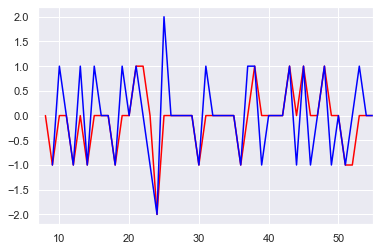

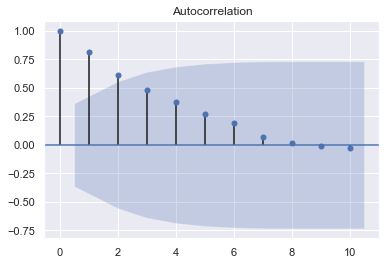

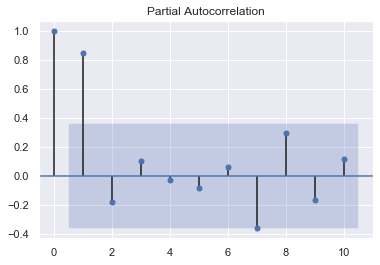

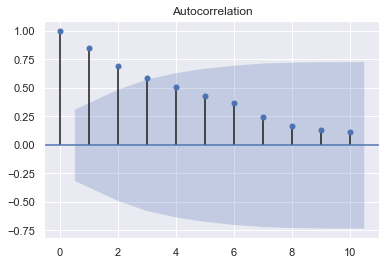

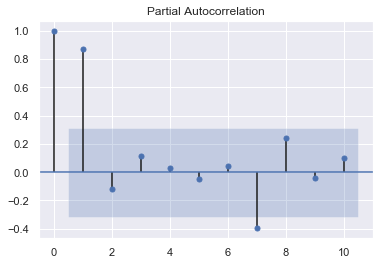

In [39]:
if state == 'study':
    X['demand'].diff(periods=1).plot(color='red')
    X['demand'].diff(periods=1).diff(periods=1).plot(color='blue')
    plot_acf(X['demand'][:-20], lags=10)
    plot_pacf(X['demand'][:-20], lags=10)
    plot_acf(X['demand'][:-10], lags=10)
    plot_pacf(X['demand'][:-10], lags=10)
    plt.show()
if state == 'train':
    X['demand'].diff(periods=1).plot(color='red')
    X['demand'].diff(periods=1).diff(periods=1).plot(color='blue')
    plot_acf(X['demand'], lags=10)
    plot_pacf(X['demand'], lags=10)
    plt.show()

In [45]:
if state == 'study':
    y_pred_arimax = list()
    rmse_arimax = list()
    iteration = 0
    for learn_size in [X.shape[0]-10, X.shape[0]-20]:
        if iteration == 0:
            arimax = pf.ARIMAX(data=X[:learn_size], formula='demand~0+' + ('+'.join(f)),
                              ar=1, ma=1,integ = 1, family=pf.Normal())
        elif iteration == 1:
            arimax = pf.ARIMAX(data=X[:learn_size], formula='demand~0+' + ('+'.join(f)),
                              ar=3, ma=6, integ = 1, family=pf.Normal())
        x = arimax.fit("MLE")
        print(x.summary())

        y_diff_pred = arimax.predict(h=10, oos_data=X[learn_size:learn_size+10])
        demand_last = X.loc[learn_size, 'demand']
        y_pred = [demand_last]
        for diff in list(y_diff_pred['Differenced demand']):
            y_pred.append(y_pred[-1]+diff)
        print(y_pred)
        y_pred_arimax.append(list(y_pred[:-1]))
        #y_pred = [round(value, 0) for value in y_pred]
        rmse3 = np.sqrt(mean_squared_error(y_pred_arimax[-1],y_test))
        rmse_arimax.append(rmse3)
        iteration += 1
    print(rmse_arimax)

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced demand                  Method: MLE                                       
Start Date: 8                                           Log Likelihood: -33.5469                          
End Date: 45                                            AIC: 77.0937                                      
Number of observations: 37                              BIC: 85.1483                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.5411    0.3032     -1.7845  0.0743   (-1.1355 | 0.0532)       
MA(1)                                

In [46]:
if state == 'train':

    arimax = pf.ARIMAX(data=X, formula='demand~0+' + ('+'.join(f)),
                      ar=1, ma=1,integ = 1, family=pf.Normal())

    x = arimax.fit("MLE")
    models_dict[brand]['arimax'] = {'spec': arimax, 'features': f}
    x.summary()

In [47]:
def weighted_rmse(stats):
    return stats[0]/3+stats[1]*2/3

In [48]:
if state == 'study':
    y_pred_ensemble = list()
    for it in range(2):
        y_pred_ensemble.append([(y_pred_arimax[it][i] + y_pred_xgb[it][i] + y_pred_mr[it][i]) / 3 for i
                                in range(len(y_pred_arimax[it]))])
        rmse_ensemble = list()
    for it in range(2):
        mse4 = np.sqrt(mean_squared_error(y_pred_ensemble[it],y_test))
        rmse_ensemble.append(mse4)
    rmse_ensemble = list()
    for it in range(2):
        mse4 = np.sqrt(mean_squared_error(y_pred_ensemble[it],y_test))
        rmse_ensemble.append(mse4)
    rmse_dict = {'xgbr': weighted_rmse(rmse_xgb), 'mlr': weighted_rmse(rmse_mr),
                'arimax': weighted_rmse(rmse_arimax), 'ensemble': weighted_rmse(rmse_ensemble)}
    print('XGBR: %s' %weighted_rmse(rmse_xgb))
    print('MR: %s' %weighted_rmse(rmse_mr))
    print('ARIMAX: %s' %weighted_rmse(rmse_arimax))
    print('Ensemble: %s' %weighted_rmse(rmse_ensemble))
    best_model = min(rmse_dict, key=rmse_dict.get)
    models_dict[brand]['best_model'] = {'model': best_model, 'rmse': rmse_dict[best_model]}

XGBR: 1.3619000145768374
MR: 1.7082994794743809
ARIMAX: 1.170312975102819
Ensemble: 1.3016347648430728


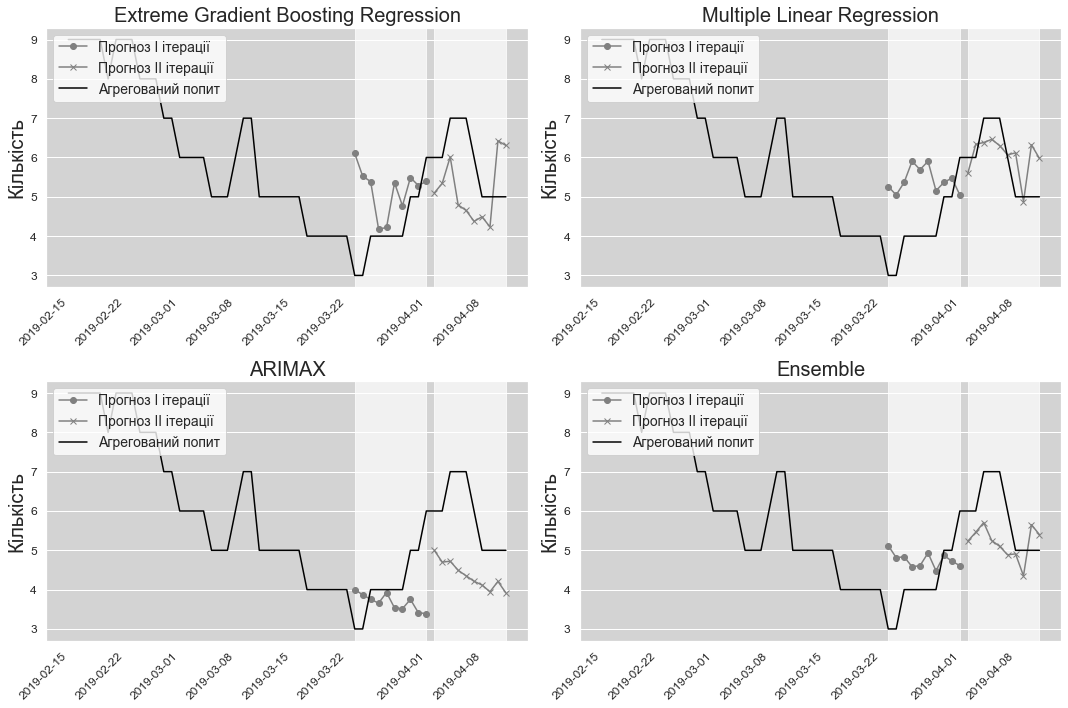

In [49]:
if state == 'study':
    fig = plt.figure(figsize=(15, 10))

    pl_1 = fig.add_subplot(2, 2, 1)
    pl_1.patch.set_facecolor('lightgrey')
    pl_1.plot(pd.Series(data=y_pred_xgb[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_1.plot(pd.Series(data=y_pred_xgb[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_1.plot(series.dropna(), color='black')
    pl_1.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_1.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    plt.title('Extreme Gradient Boosting Regression', fontsize=20)
    pl_1.xaxis.grid()
    pl_1.set_ylabel("Кількість", fontsize=20)
    pl_1.tick_params(labelsize=12)
    pl_1.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')


    pl_2 = fig.add_subplot(2, 2, 2, sharex=pl_1, sharey=pl_1)
    pl_2.patch.set_facecolor('lightgrey')
    pl_2.plot(pd.Series(data=y_pred_mr[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_2.plot(pd.Series(data=y_pred_mr[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_2.xaxis.grid()
    pl_2.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_2.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    pl_2.plot(series.dropna(), color='black')
    pl_2.set_ylabel("Кількість", fontsize=20)
    plt.title('Multiple Linear Regression', fontsize=20)
    pl_2.tick_params(labelsize=12)
    pl_2.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')


    pl_3 = fig.add_subplot(2, 2, 3, sharex=pl_1, sharey=pl_1)
    pl_3.patch.set_facecolor('lightgrey')
    pl_3.plot(pd.Series(data=y_pred_arimax[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_3.plot(pd.Series(data=y_pred_arimax[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_3.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_3.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    pl_3.plot(series.dropna(), color='black')
    pl_3.xaxis.grid()
    pl_3.set_ylabel("Кількість", fontsize=20)
    plt.title('ARIMAX', fontsize=20)
    pl_3.tick_params(labelsize=12)
    pl_3.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')


    pl_4 = fig.add_subplot(2, 2, 4, sharex=pl_1, sharey=pl_1)
    pl_4.patch.set_facecolor('lightgrey')
    pl_4.plot(pd.Series(data=y_pred_ensemble[0], index = X['sc_date'][-20:-10]), marker='o', color='grey')
    pl_4.plot(pd.Series(data=y_pred_ensemble[1], index = X['sc_date'][-10:]), marker='x', color='grey')
    pl_4.plot(series.dropna(), color='black')
    pl_4.axvspan(series.dropna().index[-20], series.dropna().index[-11], alpha=0.7, color='white')
    pl_4.axvspan(series.dropna().index[-10], series.dropna().index[-1], alpha=0.7, color='white')
    pl_4.xaxis.grid()
    pl_4.set_ylabel("Кількість", fontsize=20)
    plt.title('Ensemble', fontsize=20)
    pl_4.tick_params(labelsize=12)
    pl_4.legend(('Прогноз І ітерації', 'Прогноз ІІ ітерації', 'Агрегований попит'), loc='upper left',
                fontsize=14, facecolor='white')
    
    #fig.autofmt_xdate()
    
    plt.setp(pl_1.get_xticklabels(), rotation=45, ha="right")
    plt.setp(pl_2.get_xticklabels(), rotation=45, ha="right")
    plt.setp(pl_3.get_xticklabels(), rotation=45, ha="right")
    plt.setp(pl_4.get_xticklabels(), rotation=45, ha="right")
    
    fig.tight_layout()
    plt.show()

In [ ]:
with open('demand_models_spec.pkl', 'wb') as f:
    pickle.dump(models_dict, f)

In [ ]:
models_dict[brand]['best_model']

In [ ]:
models_dict